In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

plt.close('all') 


In [19]:
# Fixed params for BaH
global pi, h, hbar, c, eps0, m, lam, k, gamma, tau, Is, delta, w1, w2, Ipcf, w3, Ptot, Itot
global tau_sp, gamma_sp, ng, ne, gamma_eff
pi = 3.1415
h = 6.63e-34
hbar = h/(2*pi)
c = 299792458
eps0 = 8.854e-12

m = 41e-3/6.02e23 # mass of a CaH molecule
lam = 695e-9
k = 2*pi/lam

tau_sp = 33e-9 # spontaneous lifetime
gamma_sp = 1 / tau_sp * 0.987
ng = 12
ne = 4    
gamma_eff = gamma_sp  * ne / (ng + ne) * 1 #.45 is measured rate, from deflection
Is = pi * h * c / (3 * lam**3 * tau_sp) * 2 * ng**2 / (ng + ne)

In [20]:
# Fct for initialization
def init(n_par,vf,dvf,r,T):
    import numpy as np
    std = np.sqrt(1.38e-23*T/m)
    x = np.full(n_par, 0)
    vx = np.random.normal(vf,dvf,n_par)
    
    radius=np.sqrt(np.random.random(n_par))*r
    angle= np.random.random(n_par)*pi*2
    y = radius*np.cos(angle)
    z = radius*np.sin(angle)

    speed=np.sqrt(np.random.random(n_par))*std
    angle= np.random.random(n_par)*pi*2
    vy = np.random.randn(n_par)*std
    vz = np.random.randn(n_par)*std
    return np.array([x,y,z,vx,vy,vz])

def plot_monitor(mol):
    sns.jointplot(x=mol[1], y=mol[2], kind="hex").set_axis_labels("y_pos", "z_pos")
    plt.show()
    sns.jointplot(x=mol[4], y=mol[5], kind="hex").set_axis_labels("y_vel", "z_vel");
    plt.show()
    sns.distplot(mol[3])
    plt.show()
    
def F_slow_one_laser(y,z,vz,Il):
    s0 = Il/Is
    delta=80e6
    omega_D = 2*pi*vz/lam
    F_plus = hbar*k*s0 *gamma_eff/2/(1+s0+(2*(delta*2*pi-omega_D)/ gamma_sp)**2 )
    return F_plus


    
def skim_round(mol,r):
    ii = [i for i in range(len(mol)) if np.absolute(mol[1,i])**2 + np.absolute(mol[2,i])**2 > (r/2)**2]
    mol = np.delete(mol,ii,axis=1)
    npr=n_par-len(ii)
    return mol, npr


# Propagating in free space, for fixed time
def free_prop_time(mol,t):
    mol[0,:] = mol[3,:] * t + mol[0,:]
    mol[1,:] = mol[4,:] * t + mol[1,:]
    mol[2,:] = mol[5,:] * t + mol[2,:]
    return(mol)
    

# Propagating under a constant force for fixed time
def force_prop_time(mol,t):
    intensity=100*Is
    Accel=-1*F_slow(mol[1],mol[2],mol[3],intensity)/m
    
    mol[0,:] = Accel*.5*t**2 + mol[3,:] * t + mol[0,:]
    mol[1,:] = mol[4,:] * t + mol[1,:]
    mol[2,:] = mol[5,:] * t + mol[2,:]
    
    mol[3,:] = Accel*t + mol[3,:]
    return(mol)


def dat_smooth(x,window_len=11,window='hanning'):
        s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
        if window == 'flat': #moving average
            w=np.ones(window_len,'d')
        else:
            w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='valid')
        return y[int(np.floor(window_len/2)):-int(np.floor(window_len/2)-1)]
    
def Saturation_Filter(data,cutoff):
    return cutoff*np.tanh(data/cutoff)

def Count_Passed(mol,distance):
    return len(np.where(mol[0]>distance)[0])

C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


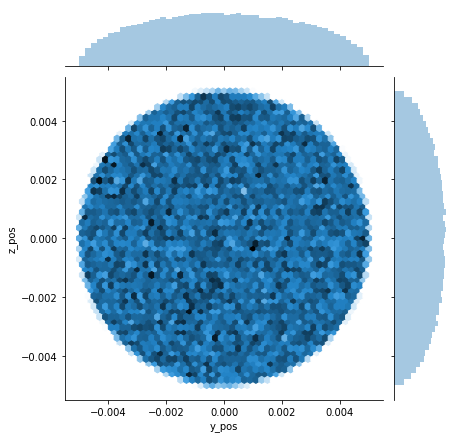

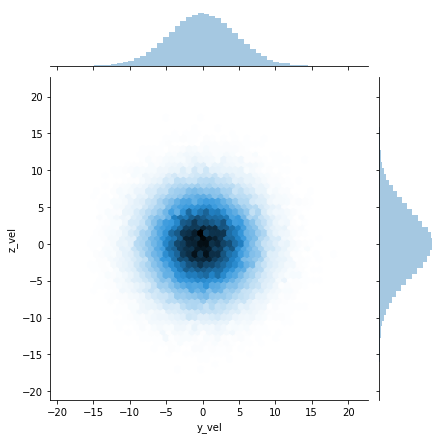

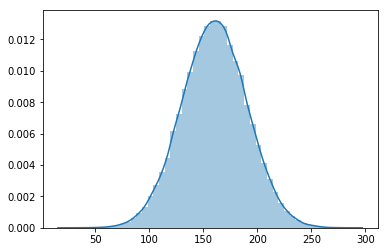

In [21]:
# Initializing
n_par = 100000
vForward=160
spreadForward=30
ro=.005;
T=.1
tprop=1E-7

mol = init(n_par,vForward,spreadForward,ro,T)
mol = free_prop_time(mol,tprop)

plot_monitor(mol)

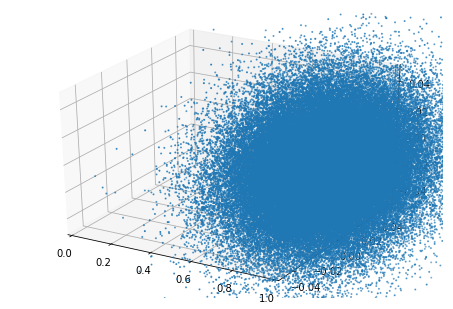

In [22]:
tprop=6e-3

mol = init(n_par,vForward,spreadForward,ro,T)
mol = free_prop_time(mol,tprop)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(mol[0],mol[1],mol[2],s=1)
ax.set_xlim([0,1])
ax.set_ylim([-.05,.05])
ax.set_zlim([-.05,.05])
plt.show()

In [23]:
def F_slow_one_laser(y,z,vz,Il):
    s0 = Il/Is
    delta=80e6
    omega_D = 2*pi*vz/lam
    F_plus = hbar*k*s0 *gamma_eff/2/(1+s0+(2*(delta*2*pi-omega_D)/ gamma_sp)**2 )
    return F_plus


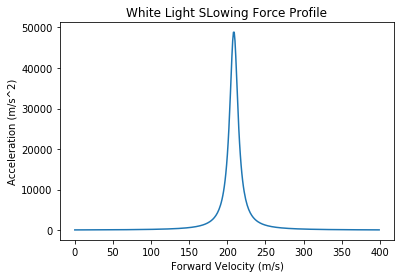

In [24]:
beamradius = 5e-3 #radius of slowing beam
Ptot = 200e-3 # total laser power (divided amongst N beams)
Ptot=Ptot
Itot = Ptot * 2 / pi / beamradius**2


def F_slow(y,z,vz,Il,Detune):
    s0 = Il/Is
    numband=1
    s0=s0/numband
    gap=0
    offset=Detune
    delta=((np.array([i for i in range(numband)])-numband/2)*gap+offset)*1e6
    omega_D = 2*pi*vz/lam
    F_total=np.array([0 for i in range(len(vz))])
    for i in range(len(delta)):
        F_plus = hbar*k*s0 *gamma_eff/2/(1+s0+(2*(delta[i]*2*pi-omega_D)/ gamma_sp)**2 )
        F_total = F_total+F_plus
    return F_total



v_test=np.array([i for i in range(400)])
spectra=F_slow(0,0,v_test,Itot,300)/m;
plt.plot(v_test,spectra)
plt.xlabel("Forward Velocity (m/s)")
plt.ylabel("Acceleration (m/s^2)")
plt.title("White Light SLowing Force Profile")
plt.show()


0.0


C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


2.5
5.0
7.500000000000001
10.0


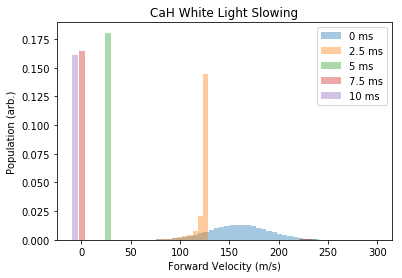

In [25]:
# Function of propagating in free space
def force_prop_time(mol,t,intensity,delnow):
    Accel=-1*F_slow(mol[1],mol[2],mol[3],intensity,delnow)/m
    
    mol[0,:] = Accel*.5*t**2 + mol[3,:] * t + mol[0,:]
    mol[1,:] = mol[4,:] * t + mol[1,:]
    mol[2,:] = mol[5,:] * t + mol[2,:]
    
    mol[3,:] = Accel*t + mol[3,:]
    return(mol)

t_step=5E-6;
t_max=10E-3;
n_step=int(t_max/t_step)

chirprate=(280)/(5e-3);
del0=325
del_min=30

mol = init(n_par,vForward,spreadForward,ro,T)
for i in range(n_step+100):
    del_now=del0-chirprate*i*t_step
    if del_now<del_min:
        del_now=del_min
    mol = force_prop_time(mol,t_step,Itot,del_now)
    if np.mod(i,1000/2)==0:
        print(i*t_step*1e3)
        sns.distplot(mol[3],kde=False,label="test",norm_hist=True)
        
        
plt.legend(['0 ms','2.5 ms','5 ms','7.5 ms','10 ms'])     
plt.xlabel("Forward Velocity (m/s)")
plt.ylabel("Population (arb.)")
plt.title("CaH White Light Slowing")

plt.show()



C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


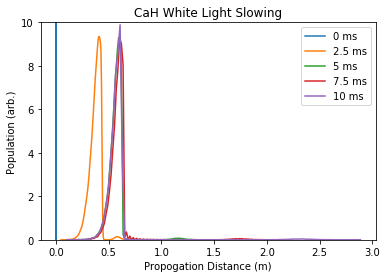

In [26]:
t_max=10E-3;
n_step=int(t_max/t_step)
mol = init(n_par,vForward,spreadForward,ro,T)
for i in range(n_step+100):
    del_now=del0-chirprate*i*t_step
    if del_now<del_min:
        del_now=del_min
    mol = force_prop_time(mol,t_step,Itot,del_now)
    if np.mod(i,500)==0:
        sns.distplot(mol[0],hist=False,label="test")
        
        
plt.legend(['0 ms','2.5 ms','5 ms','7.5 ms','10 ms'])   
plt.xlabel("Propogation Distance (m)")
plt.ylabel("Population (arb.)")
plt.title("CaH White Light Slowing")
plt.ylim([0,10])
plt.show()



In [27]:
def MOT_Captured(cap_tracker,mol,MOT_loc,r_trap,v_cap):
    dtrap=np.sqrt((mol[0]-MOT_loc)**2+mol[1]**2+mol[2]**2)
    speed=np.sqrt((mol[3])**2+mol[4]**2+mol[5]**2)
    captured=np.where((dtrap<r_trap) & (speed<vcap))[0]
    cap_tracker[captured]=1
    return cap_tracker

#t_step=50E-6;
t_max=30E-3;
n_step=int(t_max/t_step)

distance=.5 #distance to MOT
size=12.7e-3  # Size of the MOT
vcap=10   # Capture velocity

mol = init(n_par,vForward,spreadForward,ro,T)
cap_tracker=0*mol[0]

for i in range(n_step+100):
    del_now=del0-chirprate*i*t_step
    if del_now<del_min:
        del_now=del_min
    mol = force_prop_time(mol,t_step,Itot,del_now)
    cap_tracker=MOT_Captured(cap_tracker,mol,distance,size,vcap)
    
np.sum(cap_tracker)/n_par*100 # % of the molecules we capture


0.602

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


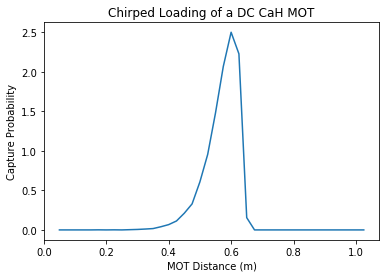

In [28]:
distance=1.5 #distance to MOT

d_vec=[]
cap_vec=[]
for j in range(40):
    distance = j*.025+.05
    mol = init(n_par,vForward,spreadForward,ro,T)
    cap_tracker=0*mol[0]
    print(j)

    for i in range(n_step+100):
        del_now=del0-chirprate*i*t_step
        if del_now<del_min:
            del_now=del_min
        mol = force_prop_time(mol,t_step,Itot,del_now)
        cap_tracker=MOT_Captured(cap_tracker,mol,distance,size,vcap)
    d_vec.append(distance)
    cap_vec.append(np.sum(cap_tracker)/n_par*100) # % of the molecules we capture
    
plt.plot(d_vec,cap_vec)    
plt.xlabel("MOT Distance (m)")
plt.ylabel("Capture Probability")
plt.title("Chirped Loading of a DC CaH MOT")
plt.show()